## Implement the reading of boundaries as masks instead of dataframe with vertices

In [1]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

In [2]:
from insitupy import XeniumData
import zarr
import dask
from pathlib import Path
import numpy as np
import pandas as pd

In [3]:
xd_data = Path(r"C:\Users\ge37voy\OneDrive - TUM\data\2315_VascularCancer_Mogler\2315-02-glioblastoma\20240112__122324__2315-02-Glioblastoma\output-XETG00050__0017321__N-436-21-N__20240112__124239")
savepath = Path("C:/Users/ge37voy/Downloads/tmp/savetest2")

In [4]:
xd = XeniumData(xd_data)

In [5]:
xd.load_all()

Reading annotations...
No `annotations` modality found.
Reading cells...
Reading images...
Reading regions...
No `regions` modality found.
Reading transcripts...


In [6]:
xd

XeniumData
Slide ID:	0017321
Sample ID:	N-436-21-N
Data path:	C:\Users\ge37voy\OneDrive - TUM\data\2315_VascularCancer_Mogler\2315-02-glioblastoma\20240112__122324__2315-02-Glioblastoma
Data folder:	output-XETG00050__0017321__N-436-21-N__20240112__124239
Metadata file:	experiment_modified.xenium
    ➤ images
       nuclei:	(20476, 22820)
       HE:	(20476, 22820, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 72004 × 314
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
           var: 'gene_ids', 'feature_types', 'genome'
           obsm: 'spatial'
           varm: 'binned_expression'
       boundaries
           BoundariesData object with 2 entries:
               nuclear
               cellular
    ➤ transcripts
       DataFrame with shape 13063085 x 10

In [7]:
xd.show()

In [58]:
xdcrop = xd.crop(shape_layer="Shapes")

In [59]:
xdcrop

XeniumData
Slide ID:	0017321
Sample ID:	N-436-21-N
Data path:	C:\Users\ge37voy\OneDrive - TUM\data\2315_VascularCancer_Mogler\2315-02-glioblastoma\20240112__122324__2315-02-Glioblastoma
Data folder:	output-XETG00050__0017321__N-436-21-N__20240112__124239
Metadata file:	experiment_modified.xenium
    ➤ images
       nuclei:	(1351, 1013)
       HE:	(1351, 1013, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 490 × 314
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
           var: 'gene_ids', 'feature_types', 'genome'
           obsm: 'spatial'
       boundaries
           BoundariesData object with 2 entries:
               nuclear
               cellular
    ➤ transcripts
       DataFrame with shape 94921 x 10

## Read binned expression data

In [18]:
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

In [19]:
trans_file = xd_data / "transcripts.zarr.zip"

In [61]:
# read zarr store
t = zarr.open(trans_file, mode="r")

# extract sparse array
data_gene = t["density/gene"]
data = data_gene["data"][:]
indices = data_gene["indices"][:]
indptr = data_gene["indptr"][:]
cols = data_gene.attrs["cols"]
rows = data_gene.attrs["rows"]
gene_names = data_gene.attrs["gene_names"]
n_genes = len(gene_names)

sarr = csr_matrix((data, indices, indptr))

# reshape to get binned data
arr = sarr.toarray()
arr = arr.reshape((n_genes, rows, cols))

# select only genes that are available in the adata object
gene_mask = [elem in xd.cells.matrix.var_names for elem in gene_names]
arr = arr[gene_mask]

In [62]:
img = arr[0]

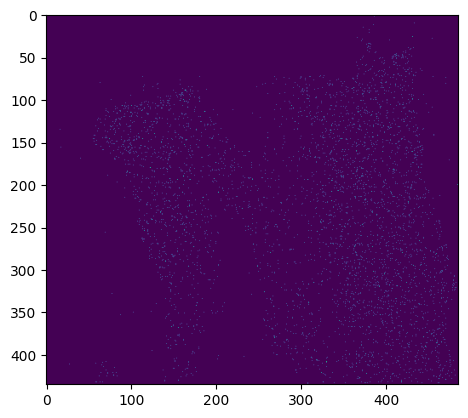

In [63]:
plt.imshow(img)

In [64]:
xd.cells.matrix.varm["binned_expression"] = arr

In [65]:
xd.cells.matrix.varm

AxisArrays with keys: binned_expression

In [66]:
xd.cells

matrix
    AnnData object with n_obs × n_vars = 72004 × 314
    obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'
    varm: 'binned_expression'
boundaries
    BoundariesData object with 2 entries:
        nuclear
        cellular

In [25]:
xd.show()

In [64]:
savepath

WindowsPath('C:/Users/ge37voy/Downloads/tmp/savetest2')

In [67]:
xdcrop.save(savepath, overwrite=True)

In [75]:
savepath.with_suffix(".zip")

WindowsPath('C:/Users/ge37voy/Downloads/tmp/savetest2.zip')

In [76]:
xdcrop.save(savepath.parent / "savetestnew.zip", overwrite=True)

In [77]:
xx = XeniumData(savepath.parent / "savetestnew.zip")

FileNotFoundError: No such directory found: C:\Users\ge37voy\Downloads\tmp\savetestnew.zip

In [79]:
with open(savepath, mode='r') as folder:
    print(folder.read())

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\ge37voy\\Downloads\\tmp\\savetest2'

In [69]:
xx

XeniumData
Slide ID:	0017321
Sample ID:	N-436-21-N
Data path:	C:\Users\ge37voy\Downloads\tmp
Data folder:	savetest2
Metadata file:	.xeniumdata

In [70]:
xx.load_all()

Reading annotations...
No `annotations` modality found.
Reading cells...
Reading images...
Reading regions...
No `regions` modality found.
Reading transcripts...


c:\Users\ge37voy\AppData\Local\miniconda3\envs\insitupy\lib\site-packages\anndata\__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [71]:
xx.show()

In [72]:
xx.cells.matrix.obs_names

Index(['abkihkfc-1', 'abkjinnh-1', 'abkkmfcn-1', 'abkkphpo-1', 'abkneaim-1',
       'ablajmko-1', 'ablekjpl-1', 'ablgdcnn-1', 'ablgjnhk-1', 'ablhfipk-1',
       ...
       'cefmpjll-1', 'cefnhpag-1', 'cefopccm-1', 'cefpohig-1', 'cegalddb-1',
       'cegalehj-1', 'cegbdana-1', 'cegbibjj-1', 'cegbinmn-1', 'cegcddgg-1'],
      dtype='object', length=490)

In [47]:
str(zarrzipout).split(".", 1)

['C:\\Users\\ge37voy\\Downloads\\tmp\\test3', 'zarr.zip']

In [48]:
str(zarrout).split(".", 1)

['C:\\Users\\ge37voy\\Downloads\\tmp\\test2', 'zarr']

In [33]:
zarrout = savepath.parent / "test2.zarr"
zarrzipout = savepath.parent / "test3.zarr.zip"

In [37]:
xdcrop.cells.boundaries.nuclear

dask.array<rechunk-merge, shape=(1493, 1327), dtype=uint32, chunksize=(1493, 1327), chunktype=numpy.ndarray>

In [34]:
with zarr.ZipStore(zarrzipout, mode='w') as store:
    xdcrop.cells.boundaries.nuclear.to_zarr(store, overwrite=True)

In [35]:
d = dask.array.from_zarr(zarrzipout)

In [36]:
d

dask.array<from-zarr, shape=(1493, 1327), dtype=uint32, chunksize=(1493, 1327), chunktype=numpy.ndarray>

In [27]:
xdcrop.cells.boundaries.nuclear.to_zarr(zarrout, overwrite=True)

In [13]:
xdcrop.cells.boundaries.nuclear.to_zarr(zarrout)

ValueError: Attempt to save array to zarr with irregular chunking, please call `arr.rechunk(...)` first.

In [2]:
xdcrop.cells.boundaries.cellular

NameError: name 'xdcrop' is not defined

In [22]:
xdcrop.show()

In [14]:
xdcrop.cells.boundaries.nuclear

dask.array<getitem, shape=(286, 286), dtype=uint32, chunksize=(286, 218), chunktype=numpy.ndarray>

In [27]:
isinstance(True, bool)

True

In [28]:
xd.cells.boundaries.cellular[30:1221, 23:234]

dask.array<getitem, shape=(1191, 211), dtype=uint32, chunksize=(610, 211), chunktype=numpy.ndarray>

In [31]:
cells_zarr_file = xd_data / "cells.zarr.zip"

In [32]:
cells = zarr.open(cells_zarr_file, mode="r")

In [33]:
print(cells.tree())

/
 ├── cell_id (72004, 2) uint32
 ├── cell_summary (72004, 7) float64
 ├── masks
 │   ├── 0 (20476, 22820) uint32
 │   ├── 1 (20476, 22820) uint32
 │   └── homogeneous_transform (4, 4) float32
 ├── polygon_num_vertices (2, 72004) int32
 ├── polygon_vertices (2, 72004, 26) float32
 └── seg_mask_value (72004,) uint32


In [36]:
cells.cell_id[:]

array([[     41392,          1],
       [     50263,          1],
       [     95487,          1],
       ...,
       [3901099234,          1],
       [3901132806,          1],
       [3901252498,          1]], dtype=uint32)

In [40]:
cells.cell_summary[:]

array([[1357.34326172, 1689.22619629,  425.86860921, ..., 1687.41662598,
          83.35844053,   18.        ],
       [1355.0333252 , 1706.20385742,  321.28673041, ..., 1708.40820312,
          62.40593977,   15.        ],
       [1371.2824707 , 1702.32226562,  160.89172459, ..., 1706.76733398,
          12.91468797,   18.        ],
       ...,
       [4146.4609375 ,  906.07733154,   95.37000346, ...,  908.21130371,
          26.01000094,   15.        ],
       [4206.87988281,  909.21466064,   54.63906448, ...,  910.71502686,
          10.56656288,   15.        ],
       [4200.67236328,  915.49005127,   74.95937772, ...,  916.30627441,
          44.97562663,   15.        ]])

In [42]:
cells.seg_mask_value[:]

array([    1,     2,     3, ..., 72002, 72003, 72004], dtype=uint32)

In [44]:
nuclear_masks = dask.array.from_zarr(cells_zarr_file, component="masks/0")
cellular_masks = dask.array.from_zarr(cells_zarr_file, component="masks/1")

In [51]:
np.max(nuclear_masks.compute())

72004

In [55]:
pd.read_parquet(r"C:\Users\ge37voy\OneDrive - TUM\data\2315_VascularCancer_Mogler\2315-02-glioblastoma\20240112__122324__2315-02-Glioblastoma\output-XETG00050__0017321__N-436-21-N__20240112__124239\cell_boundaries.parquet")

,cell_id,vertex_x,vertex_y
0,aaaakbla-1,1352.987549,1677.475098
1,aaaakbla-1,1347.462524,1682.362549
2,aaaakbla-1,1347.462524,1686.612549
3,aaaakbla-1,1345.975098,1690.225098
4,aaaakbla-1,1343.425049,1693.412598
...,...,...,...
936034,oiiigdjc-1,4204.312500,920.125000
936035,oiiigdjc-1,4204.950195,917.150024
936036,oiiigdjc-1,4204.950195,913.962524
936037,oiiigdjc-1,4201.762695,909.925049


In [ ]:
pd.read_parquet(r"C:\Users\ge37voy\OneDrive - TUM\data\2315_VascularCancer_Mogler\2315-02-glioblastoma\20240112__122324__2315-02-Glioblastoma\output-XETG00050__0017321__N-436-21-N__20240112__124239\cells.parquet")

,cell_id,vertex_x,vertex_y
0,aaaakbla-1,1352.987549,1677.475098
1,aaaakbla-1,1347.462524,1682.362549
2,aaaakbla-1,1347.462524,1686.612549
3,aaaakbla-1,1345.975098,1690.225098
4,aaaakbla-1,1343.425049,1693.412598
...,...,...,...
936034,oiiigdjc-1,4204.312500,920.125000
936035,oiiigdjc-1,4204.950195,917.150024
936036,oiiigdjc-1,4204.950195,913.962524
936037,oiiigdjc-1,4201.762695,909.925049


In [23]:
nuclear_masks

dask.array<from-zarr, shape=(20476, 22820), dtype=uint32, chunksize=(640, 1427), chunktype=numpy.ndarray>

In [ ]:
nuclear_masks

dask.array<from-zarr, shape=(20476, 22820), dtype=uint32, chunksize=(640, 1427), chunktype=numpy.ndarray>

In [24]:
nsubres = 6
nuc_pyramid = [nuclear_masks]
cell_pyramid = [cellular_masks]

nucsub = nuclear_masks.copy()
cellsub = cellular_masks.copy()
for n in range(nsubres):
    nucsub = nucsub[::2, ::2]
    cellsub = cellsub[::2, ::2]
    nuc_pyramid.append(nucsub)
    cell_pyramid.append(cellsub)

In [25]:
nuc_pyramid

[dask.array<from-zarr, shape=(20476, 22820), dtype=uint32, chunksize=(640, 1427), chunktype=numpy.ndarray>,
 dask.array<getitem, shape=(10238, 11410), dtype=uint32, chunksize=(320, 714), chunktype=numpy.ndarray>,
 dask.array<getitem, shape=(5119, 5705), dtype=uint32, chunksize=(160, 357), chunktype=numpy.ndarray>,
 dask.array<getitem, shape=(2560, 2853), dtype=uint32, chunksize=(80, 179), chunktype=numpy.ndarray>,
 dask.array<getitem, shape=(1280, 1427), dtype=uint32, chunksize=(40, 90), chunktype=numpy.ndarray>,
 dask.array<getitem, shape=(640, 714), dtype=uint32, chunksize=(20, 45), chunktype=numpy.ndarray>,
 dask.array<getitem, shape=(320, 357), dtype=uint32, chunksize=(10, 23), chunktype=numpy.ndarray>]

In [26]:
xd.show()

In [27]:
pixel_size = xd.metadata["pixel_size"]

In [28]:
xd.viewer.add_labels(nuc_pyramid, name='nuclei_mask', scale=(pixel_size, pixel_size))
xd.viewer.add_labels(cell_pyramid, name='cell_mask', scale=(pixel_size, pixel_size))

<Labels layer 'cell_mask' at 0x24ae9066d60>

In [14]:
xd.cells.boundaries

BoundariesData object with 2 entries:
    cellular
    nuclear

In [8]:
cells["masks/0"]

<zarr.core.Array '/masks/0' (20476, 22820) uint32 read-only>